# Import Libraries

In [1]:
import os, torch, copy, cv2, sys, random
# from datetime import datetime, timezone, timedelta
import wandb

from PIL import Image
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms

import torchvision.models as models


import albumentations as A
from albumentations.pytorch import ToTensorV2

# Set Arguments & hyperparameters

In [2]:
RANDOM_SEED = 1994

torch.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

In [3]:
DATA_DIR = '../data'
NUM_CLS = 2

os.environ['CUDA_VISIBLE_DEVICES'] = "0"

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'현재 DEVICE : {DEVICE}')

현재 DEVICE : cuda


# Dataloader

In [4]:
class CustomDataset(Dataset):
    def __init__(self, data_dir, mode, aug, train_size=0.9):
        self.data_dir = data_dir
        self.mode = mode
        self.aug = aug
        self.trina_size = train_size
        
        
        self.db = self.data_loader()
        
        if self.mode == 'train':
            train_index = int(len(self.db) * train_size)
            self.db = self.db[:train_index]
        elif self.mode =='val':
            train_index = int(len(self.db) * train_size)
            self.db = self.db[train_index:]
            self.db.reset_index(inplace=True)
        else:
            print(f'change mode! train or val')
        
        
    def data_loader(self):
        print('Loading ' + self.mode + ' dataset..')
        # 경로 존재하지 않을 경우 error
        if not os.path.isdir(self.data_dir):
            print(f'!!! Cannot find {self.data_dir}... !!!')
            sys.exit()
            
        db = pd.read_csv(os.path.join(self.data_dir, 'train.csv'))
        
        return db
    
    def __len__(self):
        return len(self.db)
    
    def __getitem__(self, index):
        data = copy.deepcopy(self.db.loc[index])
        
        # data_dir/train/001.png
        img = cv2.imread(os.path.join(self.data_dir, 'train', data['file_name']))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if not isinstance(img, np.ndarray):
            raise IOError("Fail to read %s" % data['file_name'])
        

        trans_image = self.aug(image=img)["image"]
        
        # return img, label
        return trans_image, data['COVID']
        
        

# Utils

In [5]:
class LossEarlyStopper():
    """Early stopper
    
    Attributes:
        patience (int): loss가 줄어들지 않아도 학습할 epoch 수
        patience_counter (int): loss 가 줄어들지 않을 때 마다 1씩 증가, 감소 시 0으로 리셋
        min_loss (float): 최소 loss
        stop (bool): True 일 때 학습 중단
    """

    def __init__(self, patience: int)-> None:
        self.patience = patience

        self.patience_counter = 0
        self.min_loss = np.Inf
        self.stop = False
        self.save_model = False

    def check_early_stopping(self, loss: float)-> None:
        """Early stopping 여부 판단"""  

        if self.min_loss == np.Inf:
            self.min_loss = loss
            return None

        elif loss > self.min_loss:
            self.patience_counter += 1
            msg = f"Early stopping counter {self.patience_counter}/{self.patience}"

            if self.patience_counter == self.patience:
                self.stop = True
                
        elif loss <= self.min_loss:
            self.patience_counter = 0
            self.save_model = True
            msg = f"Validation loss decreased {self.min_loss} -> {loss}"
            self.min_loss = loss
        
        print(msg)
    

class Trainer():
    def __init__(self, loss_fn, model, device, metric_fn, optimizer=None, scheduler=None):
        self.loss_fn = loss_fn
        self.model = model
        self.device = device
        self.metric_fn = metric_fn
        self.optimizer = optimizer
        self.scheduler = scheduler
        
    def train_epoch(self, dataloader, epoch_index):

        # train mode
        self.model.train()
        
        train_total_loss = 0
        target_lst = []
        pred_lst = []
        prob_lst = []

        for batch_index, (img, label) in enumerate(dataloader):
            img = img.to(self.device)
            label = label.to(self.device).float()
            
            # predict
            pred = self.model(img)
            
            # loss
            loss = loss_fn(pred[:, 1], label)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            self.scheduler.step()
            
            train_total_loss += loss.item()
            
            prob_lst.extend(pred[:, 1].cpu().tolist())
            target_lst.extend(label.cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())
            
        self.train_mean_loss = train_total_loss / batch_index
        self.train_score, f1 = self.metric_fn(y_pred=pred_lst, y_answer=target_lst)
        
        # epoch msg
        print(f'Epoch {epoch_index}, Train loss: {self.train_mean_loss:.4f}, Acc: {self.train_score:.4f}, F1-Macro: {f1:.4f}')
        
    def validate_epoch(self, dataloader, epoch_index):
        self.model.eval()
        val_total_loss = 0
        target_lst = []
        pred_lst = []
        prob_lst = []
    
        
        for batch_index, (img, label) in enumerate(dataloader):
            img = img.to(self.device)
            label = label.to(self.device).float()

            pred = self.model(img)
            
            loss = self.loss_fn(pred[:, 1], label)
            val_total_loss += loss.item()
            
            prob_lst.extend(pred[:, 1].cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())
            target_lst.extend(label.cpu().tolist())
        
        self.val_mean_loss = val_total_loss / batch_index
        self.validation_score, f1 = self.metric_fn(y_pred=pred_lst, y_answer=target_lst)
        print(f'Epoch {epoch_index}, Val loss: {self.val_mean_loss:.4f}, Acc: {self.validation_score:.4f}, F1-Macro: {f1:.4f}')        

In [6]:
from sklearn.metrics import accuracy_score, f1_score

def get_metric_fn(y_pred, y_answer):
    """ 성능을 반환하는 함수"""
    
    assert len(y_pred) == len(y_answer), 'The size of prediction and answer are not same.'
    accuracy = accuracy_score(y_answer, y_pred)
    f1 = f1_score(y_answer, y_pred, average='macro')
    return accuracy, f1

# Model

### efficientnet

In [7]:
from efficientnet_pytorch import EfficientNet

class EfficientNetb0(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetb0, self).__init__()
        self.model = EfficientNet.from_name('efficientnet-b0', num_classes=num_classes)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.model(x)
        output = self.softmax(x)
        
        return output


### Resnet

In [14]:
class Resnet18(nn.Module):
    def __init__(self, num_classes):
        super(Resnet18, self).__init__()
        self.model = models.resnet18(pretrained=False)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.model(x)
        output = self.softmax(x)
        
        return output
    
class Resnet34_no_pretrained(nn.Module):
    def __init__(self, num_classes):
        super(Resnet34_no_pretrained, self).__init__()
        self.model = models.resnet34(pretrained=False)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.model(x)
        output = self.softmax(x)
        
        return output

class Resnet50_no_pretrained(nn.Module):
    def __init__(self, num_classes):
        super(Resnet50_no_pretrained, self).__init__()
        self.model = models.resnet50(pretrained=False)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.model(x)
        output = self.softmax(x)
        
        return output

### VGG

In [9]:
class VGG11_bn(nn.Module):
    def __init__(self, num_classes):
        super(VGG11_bn, self).__init__()
        self.model = models.vgg11_bn(pretrained=False)
        self.model.classifier[6] = nn.Linear(self.model.classifier[6].in_features, num_classes)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.model(x)
        output = self.softmax(x)
        
        return output

class VGG13_bn(nn.Module):
    def __init__(self, num_classes):
        super(VGG13_bn, self).__init__()
        self.model = models.vgg13_bn(pretrained=False)
        self.model.classifier[6] = nn.Linear(self.model.classifier[6].in_features, num_classes)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.model(x)
        output = self.softmax(x)
        
        return output
    
    
class VGG16_bn(nn.Module):
    def __init__(self, num_classes):
        super(VGG16_bn, self).__init__()
        self.model = models.vgg16_bn(pretrained=False)
        self.model.classifier[6] = nn.Linear(self.model.classifier[6].in_features, num_classes)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.model(x)
        output = self.softmax(x)
        
        return output

# GoogleNet

In [10]:
class Googlenet(nn.Module):
    def __init__(self, num_classes):
        super(Googlenet, self).__init__()
        self.model = models.googlenet(pretrained=False)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.model(x)
        if isinstance(x, torch.Tensor):
            output = self.softmax(x)
        else:
            output = self.softmax(x.logits)
        
        return output

In [11]:
# model = Resnet18_no_pretrained(2).to(DEVICE)

In [12]:
model = Googlenet(2).to(DEVICE)
a = torch.rand((1, 3, 128, 128))
output = model(a.to(DEVICE))
print(output)

/opt/conda/lib/python3.8/site-packages/torchvision/models/googlenet.py:71: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn('The default weight initialization of GoogleNet will be changed in future releases of '


tensor([[0.4620, 0.5380]], device='cuda:0', grad_fn=<SoftmaxBackward>)


# select model

In [15]:
model = Resnet18(2).to(DEVICE)

# augmentation

In [18]:
# class CustomDataset2(Dataset):
#     def __init__(self, data_dir, mode, input_shape):
#         self.data_dir = data_dir
#         self.mode = mode
#         self.input_shape = input_shape
        
#         # Loading dataset
#         self.db = self.data_loader()
        
#         # Dataset split
#         if self.mode == 'train':
#             self.db = self.db[:int(len(self.db) * 0.9)]
#         elif self.mode == 'val':
#             self.db = self.db[int(len(self.db) * 0.9):]
#             self.db.reset_index(inplace=True)
#         else:
#             print(f'!!! Invalid split {self.mode}... !!!')
            
#         # Transform function
#         self.transform = transforms.Compose([transforms.Resize(self.input_shape),
#                                              transforms.ToTensor()])

#     def data_loader(self):
#         print('Loading ' + self.mode + ' dataset..')
#         if not os.path.isdir(self.data_dir):
#             print(f'!!! Cannot find {self.data_dir}... !!!')
#             sys.exit()
        
#         # (COVID : 1, No : 0)
#         db = pd.read_csv(os.path.join(self.data_dir, 'train.csv'))
        
#         return db

#     def __len__(self):
#         return len(self.db)

#     def __getitem__(self, index):
#         data = copy.deepcopy(self.db.loc[index])

#         # Loading image
#         cvimg = cv2.imread(os.path.join(self.data_dir,'train',data['file_name']), cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
#         if not isinstance(cvimg, np.ndarray):
#             raise IOError("Fail to read %s" % data['file_name'])

#         # Preprocessing images
#         trans_image = self.transform(Image.fromarray(cvimg))

#         return trans_image, data['COVID']


# INPUT_SHAPE=338
# train_dataset = CustomDataset2(data_dir=DATA_DIR, mode='train', input_shape=INPUT_SHAPE)
# train_dataset = DataLoader(train_dataset, shuffle=True)

# def get_mean_std(dataset):
#     img = [np.asarray(image) for image, _ in train_dataset]
#     img = np.array(img)
    
#     meanR = np.mean(img[:, :, 2, :, :])
#     meanG = np.mean(img[:, :, 1, :, :])
#     meanB = np.mean(img[:, :, 0, :, :])
    
#     stdR = np.std(img[:, :, 2, :, :])
#     stdG = np.std(img[:, :, 1, :, :])
#     stdB = np.std(img[:, :, 0, :, :])
    
#     return (meanR, meanG, meanR), (stdB, stdG, stdR)

# get_mean_std(train_dataset)

In [17]:
INPUT_SHAPE = 256
BATCH_SIZE = 24

mean = (0.59760803, 0.59713995, 0.59760803)
std = (0.32656872, 0.32661003, 0.32659915)

original = A.Compose([
            A.Resize(INPUT_SHAPE, INPUT_SHAPE),
            A.Normalize(mean=mean, std=std),
            ToTensorV2()
        ])


aug1 = A.Compose([
            A.Resize(INPUT_SHAPE, INPUT_SHAPE),
            A.Normalize(mean=mean, std=std),
            A.VerticalFlip(p=0.5),
            A.HorizontalFlip(p=0.5),
            A.Rotate(limit=30, p=1),
            ToTensorV2()
        ])


aug2 = A.Compose([
            A.Resize(INPUT_SHAPE, INPUT_SHAPE),
            A.Normalize(mean=mean, std=std),
            A.

            ToTensorV2()
        ])


aug_transform = A.Compose([
            A.Resize(INPUT_SHAPE, INPUT_SHAPE),
            A.Normalize(mean=mean, std=std),
            A.GridDistortion(num_steps=5, p=0.5),
            A.Rotate(limit=30, p=0.5),
            A.VerticalFlip(p=0.5),
            A.HorizontalFlip(p=0.5),
            A.RandomCrop(int(INPUT_SHAPE*0.9), int(INPUT_SHAPE*0.9), p=0.5),
            A.Resize(INPUT_SHAPE, INPUT_SHAPE),
            ToTensorV2()
])

In [23]:
original_train = CustomDataset(data_dir=DATA_DIR, aug=aug_transform,  mode='train')
original_train1 = CustomDataset(data_dir=DATA_DIR, aug=aug1,  mode='train')
original_train2 = CustomDataset(data_dir=DATA_DIR, aug=aug2,  mode='train')

original_valid = CustomDataset(data_dir=DATA_DIR, aug=aug_transform,  mode='val')
original_valid1 = CustomDataset(data_dir=DATA_DIR, aug=aug1,  mode='val')
original_valid2 = CustomDataset(data_dir=DATA_DIR, aug=aug2,  mode='val')


train_dataset = torch.utils.data.ConcatDataset([original_train, original_train1])
valid_dataset = torch.utils.data.ConcatDataset([original_valid, original_valid1])

print(f'train : {len(train_dataset)}, valid : {len(valid_dataset)}')

# print(len(train_dataset), len(valid_dataset))
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

Loading train dataset..
Loading train dataset..
Loading train dataset..
Loading val dataset..
Loading val dataset..
Loading val dataset..
train : 1162, valid : 130


## 이미지 확인

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


img scale min: -1.8299610614776611 max: 1.2334591150283813


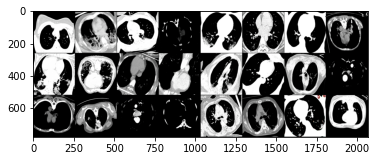

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


img scale min: -0.41498053073883057 max: 1.116729497909546


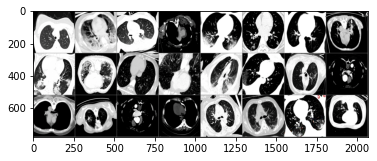

In [24]:
import matplotlib.pyplot as plt
import torchvision


def imshow_check(img):
    print(f'img scale min: {img.min()} max: {img.max()}')
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

    plt.close()

    img = img / 2 + 0.5     # unnormalize 
    print(f'img scale min: {img.min()} max: {img.max()}')
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    

# get some random training images
dataiter = iter(train_dataloader)
images, labels = dataiter.next()

# show images
imshow_check(torchvision.utils.make_grid(images))

# Train

In [26]:
EPOCHS = 30
LEARNING_RATE = 0.0003
EARLY_STOPPING_PATIENCE = 10

# Load Model
# model = custom_CNN(NUM_CLS).to(DEVICE)
# model = Resnet34_no_pretrained(2).to(DEVICE)

# # Save Initial Model
# torch.save(model.state_dict(), 'initial.pt')

# Set optimizer, scheduler, loss function, metric function
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler =  optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e5, max_lr=0.0001, epochs=EPOCHS, steps_per_epoch=len(train_dataloader))
loss_fn = nn.BCELoss()
metric_fn = get_metric_fn


# Set trainer
trainer = Trainer(loss_fn, model, DEVICE, metric_fn, optimizer, scheduler)

# Set earlystopper
early_stopper = LossEarlyStopper(patience=EARLY_STOPPING_PATIENCE)

In [27]:
name = 'resnet18_x3'

config = {
        'epochs': EPOCHS, 
        'learning rate': LEARNING_RATE, 
        'batch_size': BATCH_SIZE,
        'INPUT_SHAPE':INPUT_SHAPE,
        'EARLY_STOPPING_PATIENCE':EARLY_STOPPING_PATIENCE,
        'augmentation': ['normalize', 'distortion', 'crop', 'rotate', 'flip'],
        'train data size':len(train_dataset),
        'valid data size':len(valid_dataset)
}



wandb.init(
    config=config,
    project='CT task',
    tags=['resnet'],
    group='model search',
    name= name,
    notes='normalize',
    save_code=True,
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: codongmin (use `wandb login --relogin` to force relogin)


In [28]:
for epoch_index in tqdm(range(EPOCHS)):
    
    trainer.train_epoch(train_dataloader, epoch_index)
    trainer.validate_epoch(valid_dataloader, epoch_index)
    wandb.log({
        'train loss' : trainer.train_mean_loss,
        'train acc score' : trainer.train_score,
        'valid loss' : trainer.val_mean_loss,
        'valid acc score' : trainer.validation_score
    })
    # early_stopping check
    early_stopper.check_early_stopping(loss=trainer.val_mean_loss)

    if early_stopper.stop:
        print('Early stopped')
        break

    if early_stopper.save_model:
        check_point = {
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict()
        }
        torch.save(check_point, 'best/'+name+'best.pt')


  0% 0/30 [00:00<?, ?it/s]

Epoch 0, Train loss: 0.6911, Acc: 0.5637, F1-Macro: 0.4726


  3% 1/30 [00:15<07:35, 15.70s/it]

Epoch 0, Val loss: 0.9929, Acc: 0.5308, F1-Macro: 0.4372
Epoch 1, Train loss: 0.6029, Acc: 0.6558, F1-Macro: 0.6527
Epoch 1, Val loss: 0.8129, Acc: 0.5846, F1-Macro: 0.5578
Validation loss decreased 0.9928571462631226 -> 0.8128615617752075


  7% 2/30 [00:31<07:20, 15.74s/it]

Epoch 2, Train loss: 0.5777, Acc: 0.7065, F1-Macro: 0.7019
Epoch 2, Val loss: 0.7770, Acc: 0.6077, F1-Macro: 0.5595
Validation loss decreased 0.8128615617752075 -> 0.777005672454834


 10% 3/30 [00:47<07:09, 15.92s/it]

Epoch 3, Train loss: 0.5430, Acc: 0.7332, F1-Macro: 0.7319
Epoch 3, Val loss: 0.7812, Acc: 0.6615, F1-Macro: 0.6563
Early stopping counter 1/10


 13% 4/30 [01:03<06:53, 15.89s/it]

Epoch 4, Train loss: 0.5186, Acc: 0.7453, F1-Macro: 0.7431
Epoch 4, Val loss: 0.7857, Acc: 0.7000, F1-Macro: 0.6986
Early stopping counter 2/10


 17% 5/30 [01:19<06:38, 15.92s/it]

Epoch 5, Train loss: 0.4849, Acc: 0.7788, F1-Macro: 0.7769
Epoch 5, Val loss: 0.6868, Acc: 0.6846, F1-Macro: 0.6762
Validation loss decreased 0.777005672454834 -> 0.6868381321430206


 20% 6/30 [01:35<06:20, 15.84s/it]

Epoch 6, Train loss: 0.4918, Acc: 0.7659, F1-Macro: 0.7646
Epoch 6, Val loss: 0.6892, Acc: 0.7154, F1-Macro: 0.7133
Early stopping counter 1/10


 23% 7/30 [01:51<06:05, 15.87s/it]

Epoch 7, Train loss: 0.4433, Acc: 0.7917, F1-Macro: 0.7904
Epoch 7, Val loss: 0.7089, Acc: 0.7846, F1-Macro: 0.7770
Early stopping counter 2/10


 27% 8/30 [02:06<05:47, 15.82s/it]

Epoch 8, Train loss: 0.4337, Acc: 0.7978, F1-Macro: 0.7965
Epoch 8, Val loss: 1.0156, Acc: 0.6308, F1-Macro: 0.5877
Early stopping counter 3/10


 30% 9/30 [02:22<05:30, 15.75s/it]

Epoch 9, Train loss: 0.4426, Acc: 0.8081, F1-Macro: 0.8070
Epoch 9, Val loss: 0.6788, Acc: 0.6538, F1-Macro: 0.6538
Validation loss decreased 0.6868381321430206 -> 0.6787552416324616


 33% 10/30 [02:38<05:14, 15.74s/it]

Epoch 10, Train loss: 0.3853, Acc: 0.8236, F1-Macro: 0.8228
Epoch 10, Val loss: 0.7521, Acc: 0.7308, F1-Macro: 0.7249
Early stopping counter 1/10


 37% 11/30 [02:54<04:59, 15.78s/it]

Epoch 11, Train loss: 0.3986, Acc: 0.8330, F1-Macro: 0.8322
Epoch 11, Val loss: 0.8277, Acc: 0.6692, F1-Macro: 0.6683
Early stopping counter 2/10


 40% 12/30 [03:09<04:44, 15.80s/it]

Epoch 12, Train loss: 0.3568, Acc: 0.8503, F1-Macro: 0.8496
Epoch 12, Val loss: 0.7366, Acc: 0.7615, F1-Macro: 0.7583
Early stopping counter 3/10


 43% 13/30 [03:26<04:31, 15.97s/it]

Epoch 13, Train loss: 0.3335, Acc: 0.8675, F1-Macro: 0.8668
Epoch 13, Val loss: 0.7086, Acc: 0.6846, F1-Macro: 0.6831
Early stopping counter 4/10


 47% 14/30 [03:42<04:15, 15.94s/it]

Epoch 14, Train loss: 0.3192, Acc: 0.8666, F1-Macro: 0.8658
Epoch 14, Val loss: 0.6523, Acc: 0.7462, F1-Macro: 0.7460
Validation loss decreased 0.6787552416324616 -> 0.6522966027259827


 50% 15/30 [03:57<03:58, 15.88s/it]

Epoch 15, Train loss: 0.3120, Acc: 0.8606, F1-Macro: 0.8602
Epoch 15, Val loss: 0.8395, Acc: 0.6385, F1-Macro: 0.6288
Early stopping counter 1/10


 53% 16/30 [04:13<03:42, 15.91s/it]

Epoch 16, Train loss: 0.3089, Acc: 0.8649, F1-Macro: 0.8644
Epoch 16, Val loss: 0.8157, Acc: 0.7154, F1-Macro: 0.7133
Early stopping counter 2/10


 57% 17/30 [04:30<03:29, 16.10s/it]

Epoch 17, Train loss: 0.2920, Acc: 0.8812, F1-Macro: 0.8807
Epoch 17, Val loss: 0.6680, Acc: 0.7231, F1-Macro: 0.7198
Early stopping counter 3/10


 60% 18/30 [04:46<03:13, 16.12s/it]

Epoch 18, Train loss: 0.2638, Acc: 0.8959, F1-Macro: 0.8954
Epoch 18, Val loss: 0.6748, Acc: 0.7385, F1-Macro: 0.7321
Early stopping counter 4/10


 63% 19/30 [05:02<02:56, 16.05s/it]

Epoch 19, Train loss: 0.2526, Acc: 0.9053, F1-Macro: 0.9050
Epoch 19, Val loss: 0.6280, Acc: 0.7615, F1-Macro: 0.7612
Validation loss decreased 0.6522966027259827 -> 0.6279792487621307


 67% 20/30 [05:18<02:40, 16.10s/it]

Epoch 20, Train loss: 0.2269, Acc: 0.8950, F1-Macro: 0.8943
Epoch 20, Val loss: 0.7505, Acc: 0.7308, F1-Macro: 0.7304
Early stopping counter 1/10


 70% 21/30 [05:34<02:24, 16.04s/it]

Epoch 21, Train loss: 0.2383, Acc: 0.9045, F1-Macro: 0.9041
Epoch 21, Val loss: 0.7106, Acc: 0.7000, F1-Macro: 0.6986
Early stopping counter 2/10


 73% 22/30 [05:50<02:08, 16.01s/it]

Epoch 22, Train loss: 0.2101, Acc: 0.9071, F1-Macro: 0.9067
Epoch 22, Val loss: 0.6653, Acc: 0.7077, F1-Macro: 0.7071
Early stopping counter 3/10


 77% 23/30 [06:06<01:51, 16.00s/it]

Epoch 23, Train loss: 0.2147, Acc: 0.9139, F1-Macro: 0.9136
Epoch 23, Val loss: 0.7201, Acc: 0.7077, F1-Macro: 0.7043
Early stopping counter 4/10


 80% 24/30 [06:22<01:35, 15.97s/it]

Epoch 24, Train loss: 0.2010, Acc: 0.9208, F1-Macro: 0.9205
Epoch 24, Val loss: 0.7708, Acc: 0.7077, F1-Macro: 0.7060
Early stopping counter 5/10


 83% 25/30 [06:38<01:19, 15.85s/it]

Epoch 25, Train loss: 0.1935, Acc: 0.9208, F1-Macro: 0.9205
Epoch 25, Val loss: 0.6931, Acc: 0.7000, F1-Macro: 0.6998
Early stopping counter 6/10


 87% 26/30 [06:53<01:03, 15.85s/it]

Epoch 26, Train loss: 0.1770, Acc: 0.9225, F1-Macro: 0.9222
Epoch 26, Val loss: 0.7726, Acc: 0.7308, F1-Macro: 0.7280
Early stopping counter 7/10


 90% 27/30 [07:09<00:47, 15.79s/it]

Epoch 27, Train loss: 0.1790, Acc: 0.9260, F1-Macro: 0.9256
Epoch 27, Val loss: 0.6813, Acc: 0.7692, F1-Macro: 0.7679
Early stopping counter 8/10


 93% 28/30 [07:25<00:31, 15.86s/it]

Epoch 28, Train loss: 0.1712, Acc: 0.9277, F1-Macro: 0.9274
Epoch 28, Val loss: 0.6140, Acc: 0.7538, F1-Macro: 0.7529
Validation loss decreased 0.6279792487621307 -> 0.6140343725681305


 97% 29/30 [07:41<00:15, 15.79s/it]

Epoch 29, Train loss: 0.1871, Acc: 0.9157, F1-Macro: 0.9153
Epoch 29, Val loss: 0.7372, Acc: 0.7231, F1-Macro: 0.7220
Early stopping counter 1/10


100% 30/30 [07:57<00:00, 15.91s/it]


# Inference

In [29]:
TRAINED_MODEL_PATH = 'best/'+name+'best.pt'

In [30]:
class TestDataset(Dataset):
    def __init__(self, data_dir, input_shape):
        self.data_dir = data_dir
        self.input_shape = input_shape
        
        # Loading dataset
        self.db = self.data_loader()
        
        
        mean = [0.59760803, 0.59713995, 0.59760803]
        std = [0.32656872, 0.32661003, 0.32659915]
        # Transform function
        self.transform = transforms.Compose([transforms.Resize(self.input_shape),
                                             transforms.ToTensor(),
                                             transforms.Normalize(mean, std)])

    def data_loader(self):
        print('Loading test dataset..')
        if not os.path.isdir(self.data_dir):
            print(f'!!! Cannot find {self.data_dir}... !!!')
            sys.exit()
        
        db = pd.read_csv(os.path.join(self.data_dir, 'sample_submission.csv'))
        return db
    
    def __len__(self):
        return len(self.db)
    
    def __getitem__(self, index):
        data = copy.deepcopy(self.db.loc[index])
        
        # Loading image
        cvimg = cv2.imread(os.path.join(self.data_dir,'test',data['file_name']), cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
        if not isinstance(cvimg, np.ndarray):
            raise IOError("Fail to read %s" % data['file_name'])

        # Preprocessing images
        trans_image = self.transform(Image.fromarray(cvimg))

        return trans_image, data['file_name']

In [31]:
# Load dataset & dataloader
test_dataset = TestDataset(data_dir=DATA_DIR, input_shape=INPUT_SHAPE)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Loading test dataset..


In [32]:
# model.load_state_dict(torch.load(TRAINED_MODEL_PATH)['model'])

# Prediction
file_lst = []
pred_lst = []
prob_lst = []
model.eval()
with torch.no_grad():
    for batch_index, (img, file_num) in tqdm(enumerate(test_dataloader)):
        img = img.to(DEVICE)
        pred = model(img)
        
        file_lst.extend(list(file_num))
        pred_lst.extend(pred.argmax(dim=1).tolist())
        prob_lst.extend(pred[:, 1].tolist())

5it [00:07,  1.44s/it]


In [33]:
df = pd.DataFrame({'file_name':file_lst, 'COVID':pred_lst})
# df.sort_values(by=['file_name'], inplace=True)
df.to_csv('result/prediction_' + name+'.csv', index=False)